In [70]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations

In [71]:
# video parameters
one_pixel = 0.102 # cm
threshold = 2 # cm

#DataFrame containing DLC csv outputs grouped by original videos 
genotype_by_csv = 'Genotype_by_csv.csv'

# Folder containing the .csv files created by Deeplabcut after the whole pipeline is finished
csv_folder = 'sessions'

# Genotypes and exposure parameters
edgecolors = ['black', 'cyan', 'royalblue']
labels = ['WT', '$Syngap^{+/-}$', '$Syngap^{+/dGAP}$']
l_genotypes_per_exposure = ['WT', 'E8', 'GAP']
exposures_number = 5
l_exposures_number = [1, 2, 3, 4, 5]

In [72]:
def two_labels_behaviours(df):
    '''
    It receives a df with Deeplabcut coordinates and returns
    a list tuples, where each tuple contains the coordinates (x,y) 
    of two particular labels. That is, each tuple contains two dataframes
    each one containing 3 columns: frame, x and y of a particular label
    '''
    snout1 = df.iloc[3:,[1,2]]
    rightear1 = df.iloc[3:,[4,5]]
    leftear1 = df.iloc[3:,[7,8]]
    cervical1 = df.iloc[3:,[10,11]]
    thoracic1 = df.iloc[3:,[13,14]]
    lumbar1 = df.iloc[3:,[16,17]]
    tail1 = df.iloc[3:,[19,20]]
    snout2 = df.iloc[3:,[22,23]]
    rightear2 = df.iloc[3:,[25,26]]
    leftear2 = df.iloc[3:,[28,29]]
    cervical2 = df.iloc[3:,[31,32]]
    thoracic2 = df.iloc[3:,[34,35]]
    lumbar2 = df.iloc[3:,[37,38]]
    tail2 = df.iloc[3:,[40,41]]
    
    #all combinations of behaviours of interest = poses
    two_labels = [[snout1, snout2], [snout1, rightear2], [snout1, leftear2], [snout1,cervical2], [snout1,thoracic2], [snout1, lumbar2], [snout1, tail2] ,[rightear1, snout2], [leftear1, snout2], [cervical1, snout2],  [thoracic1, snout2], [lumbar2, snout2], [tail1, snout2]] 
    plot_titles = ["snout1, snout2", "snout1, rightear2", "snout1, leftear2", "snout1,cervical2", "snout1,thoracic2", "snout1, lumbar2", "snout1, tail2" ,"rightear1, snout2", "leftear1, snout2", "cervical1, snout2",  "thoracic1, snout2", "lumbar2, snout2", "tail1, snout2"] 
    
    return two_labels, plot_titles

In [73]:
# https://stackoverflow.com/a/52333561
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None, axis_n= None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    :param axis_n: axis number (0 or 1)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)

In [74]:
# First we read the csv file containing the names of the csv per recording and attributes of the animals recorded. 
df = pd.read_csv(genotype_by_csv)

In [75]:
df = pd.read_csv(genotype_by_csv)

l_csv_files_per_expos_per_genotype = []
l_exposure_genotype = [] # will contain an element per combination of exposure and genotype. A total of 15 elements. 
for exposure in l_exposures_number:
    for genotype in l_genotypes_per_exposure:
        #print('Exposure: ', exposure, ' Genotype: ', genotype)
        csv_list = df.loc[(df['Exposure']==exposure) & (df['SubjectGenotype']== genotype)]['DLCcsvfile'].to_list()
        l_exposure_genotype.append([exposure, genotype, csv_list])  

In [76]:
results_per_exp_geno = []
#looping through the 15 different combinations of genotype_exposure
for i, exp_geno_comb in enumerate(l_exposure_genotype):
    results_group_csv = []
    ext = '.csv'
    # finding the csv files that fit in a certain combination
    for csv_file in exp_geno_comb[2]:
        #print(' ')
        #print('*************************')
        #print(exp_geno_comb[0], ' ', exp_geno_comb[1], ' ', csv_file)
        #print('*************************')
       # csv_path = csv_folder + csv_file
        #print(csv_path)
        df = pd.read_csv(csv_file + ext)
        #print(df['DLC_dlcrnetms5_NewProjectExtraLabelMar9shuffle1_100000.1'].head())
        # getting the poses for one csv file
        dfs_tuples_from_two_labels_combinations, plot_titles = two_labels_behaviours(df) 
        #print(dfs_tuples_from_two_labels_combinations[0])
        
        single_csv_results = []
        combinations_results = []        
        #loop in csv_file to determine true interactions for each pose 
        for n, combination in enumerate(dfs_tuples_from_two_labels_combinations):
            distances = pd.concat([combination[0], combination[1]], axis=1) #create dataframe
            distances['dist_pixels']=np.linalg.norm(combination[0].values.astype(float) - combination[1].values.astype(float), axis=1) #distance between body parts of interest
            distances['dist_cm'] = distances['dist_pixels']*one_pixel #convert to cm
            distances['interaction'] = distances['dist_cm']<threshold #apply threshold
            interactions_true_table = distances.loc[distances["interaction"]== True] #locate points below threshold
            #if n == 1:
            #   print('combination: ', n)
            #   print(interactions_true_table.head(2))
            single_csv_results.append(interactions_true_table)
        
        results_group_csv.append(single_csv_results)
        
    #true interactions for all csv_files sepearated into groups [1-5, E8/GAP/WT]
    results_per_exp_geno.append(results_group_csv) 

In [77]:
group_counts = [] # occassions where a combination happens in a group. [15 groups][13 poses]
# array with the number (13) of possible poses, happening by the proximity of two labels from two rats 


# looping through each group
# results_per_exp_geno is a list with [15groups of exp_geno][csv files per group][results for the 13 poses]
# group_count is a list with [15groups of exp_geno][ global results for the 13 poses]
for j, group_results in enumerate(results_per_exp_geno):
    #print('Exposure: ', l_exposure_genotype[j][0], 'Genotype: ', l_exposure_genotype[j][1])
    #looping through each csv per group
    results_per_group = np.zeros(len(results_per_exp_geno[0][0])) 
    for i, csv_results in enumerate(group_results):
        #print("csv ", i)
        #looping through each combination for each combination per group
        for k, combination in enumerate(csv_results):
            #print("combination ", k)
            results_per_group[k] = results_per_group[k] + len(combination)
        
    #print(results_per_group)
    group_counts.append(results_per_group)

In [78]:
total_animals_count = [] # occassions where a combination happens in a group. [15 groups][13 poses]
# array with the number (13) of possible poses, happening by the proximity of two labels from two rats 


# looping through each group
# total_animals_count is a list with [15groups of exp_geno][results per csv file][results for the 13 poses]
for j, group_results in enumerate(results_per_exp_geno):
    #print('Exposure: ', l_exposure_genotype[j][0], 'Genotype: ', l_exposure_genotype[j][1])
    #looping through each csv per group
    results_per_group_per_csv = [] 
    for i, csv_results in enumerate(group_results):
        #print("csv ", i)
        #looping through each combination for each combination per group
        results_per_csv = []
        for k, combination in enumerate(csv_results):
            #print("combination ", k)
            results_per_csv.append(len(combination))
        
        results_per_group_per_csv.append(results_per_csv)
        
    #print(results_per_group)
    total_animals_count.append(results_per_group_per_csv)
#total_animals_count

In [79]:
# Transforming list of list into 2d array to transpose them so the plotting is easier
l_all_data = [] # list of arrays containing the data per csv per exposure per genotype per combination
for comb in total_animals_count:
    l_all_data.append(np.transpose(np.array(comb)))

In [80]:
# Preparing labels to look better
behavior_labels = []
for pair in plot_titles:
    new_pair = pair.replace(',', '-')
    behavior_labels.append(new_pair.replace(' ', ''))

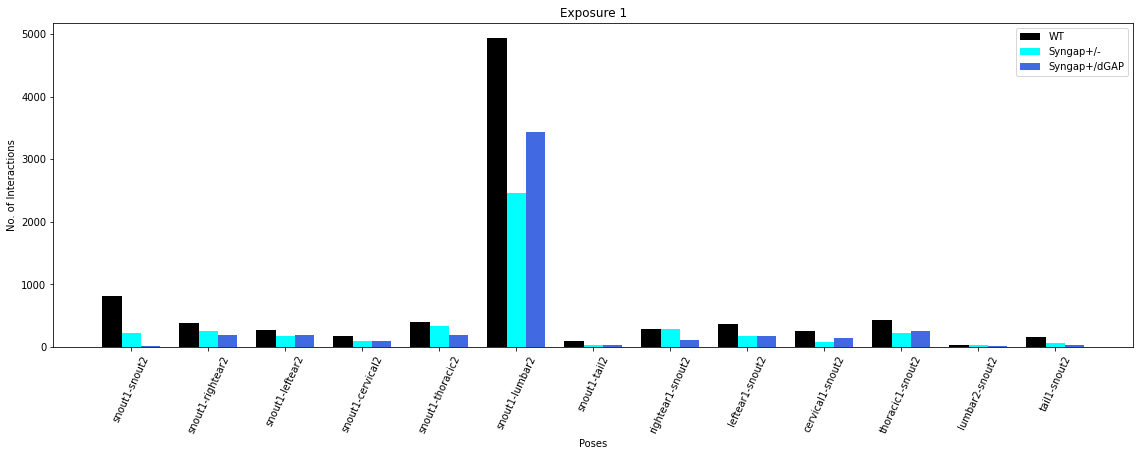

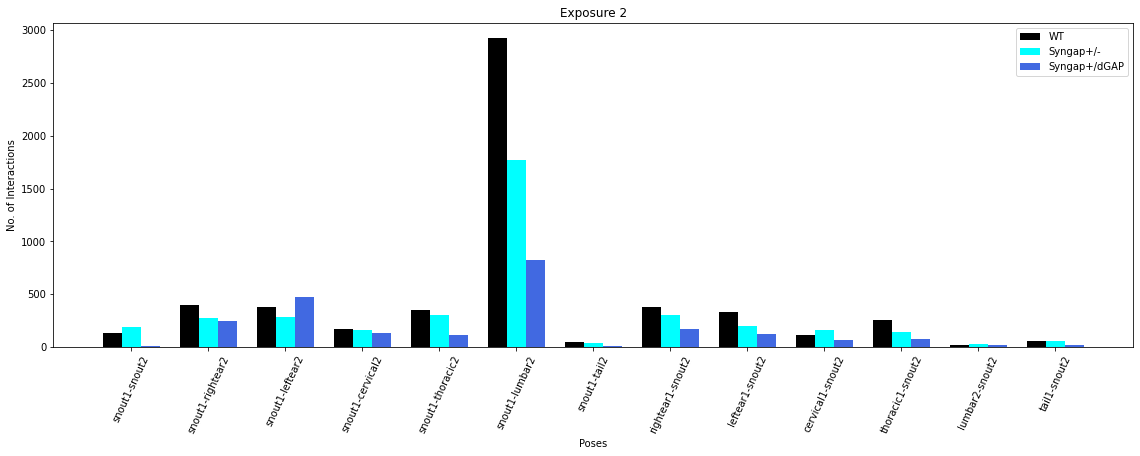

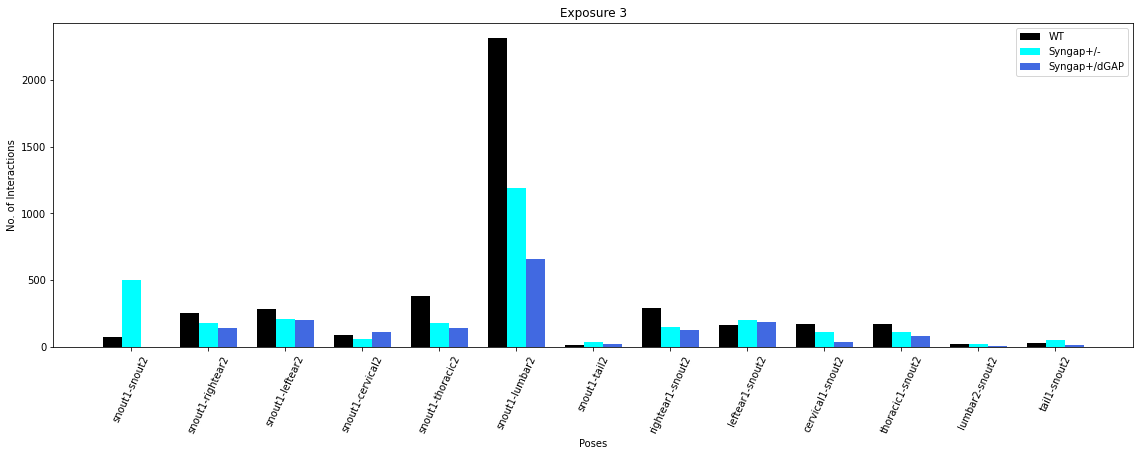

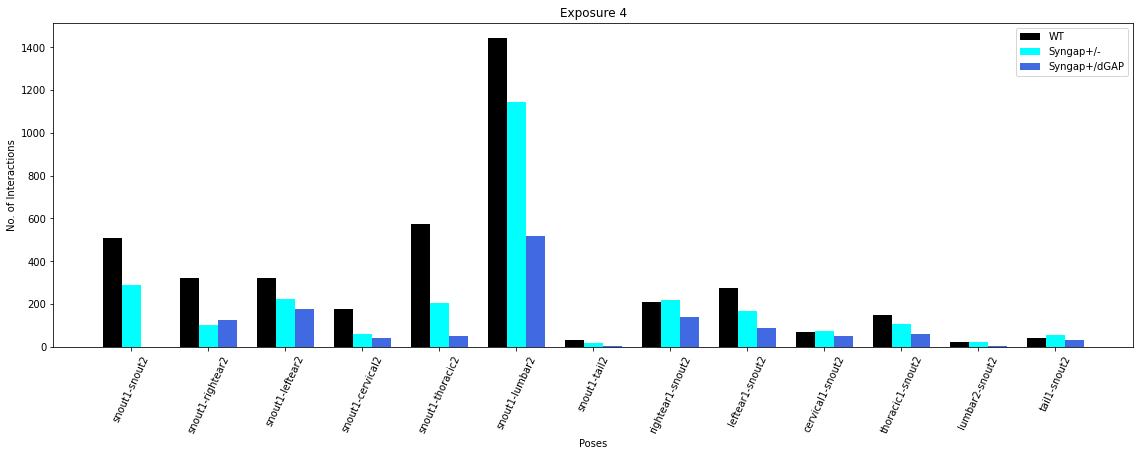

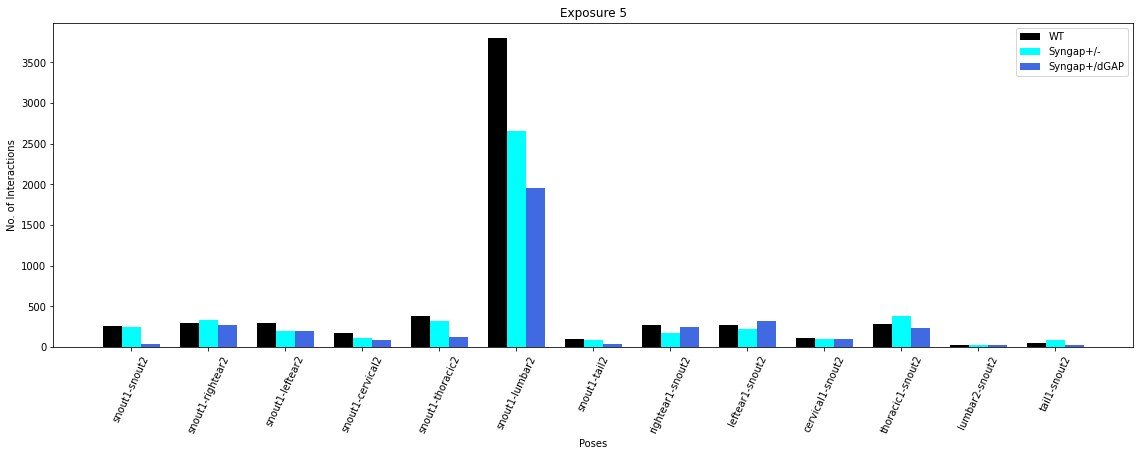

In [81]:
#l_genotypes_per_exposure = ['WT', 'E8', 'GAP']
#exposures_number = 5
#l_exposures_number = [1, 2, 3, 4, 5]

for ex, exposure in enumerate(l_exposures_number):
    data = []
    for g, genotype in enumerate(l_genotypes_per_exposure):
        #print(ex*len(l_genotypes_per_exposure) + g)
        data.append(group_counts[ex*len(l_genotypes_per_exposure) + g])        

    fig = plt.figure(figsize=(20,6))

    X = np.arange(len(behavior_labels))
    ax = fig.add_axes([0.1,0.1,0.75,0.75])
    # Now set the ticks and labels
    ax.set_xticks(np.arange(len(behavior_labels)))
    ax.set_xticklabels(behavior_labels, rotation = 65)


    ax.legend(l_genotypes_per_exposure, ncol=3)


    plt.xlabel("Poses")
    plt.ylabel("No. of Interactions")
    title = 'Exposure ' + str(exposure)
    plt.title(title)

    ax.bar(X + -0.25, data[0], color = 'black', width = 0.25, label = 'WT')
    ax.bar(X + 0.00, data[1], color = 'cyan', width = 0.25, label='Syngap+/-')
    ax.bar(X + 0.25, data[2], color = 'royalblue', width = 0.25, label='Syngap+/dGAP')
    plt.legend()
    plt.savefig('genotype_group_interaction.png', dpi=300, bbox_inches='tight', edgecolor='white')

In [82]:
# For the stats, make a list of all the possible combinations of two groups to make ttest over
ttest_comb = list(combinations(l_genotypes_per_exposure,2))
l_genotypes_per_exposure.index(ttest_comb[0][1])

1

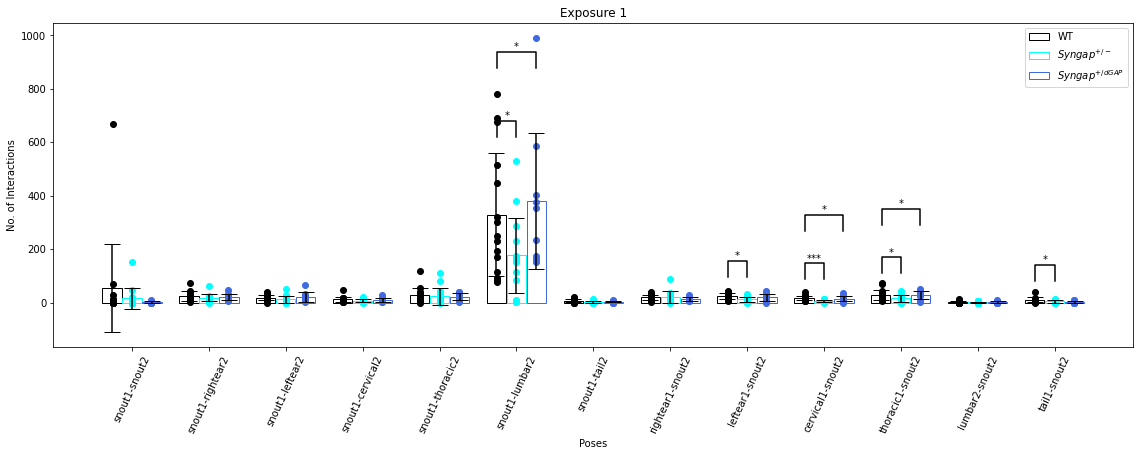

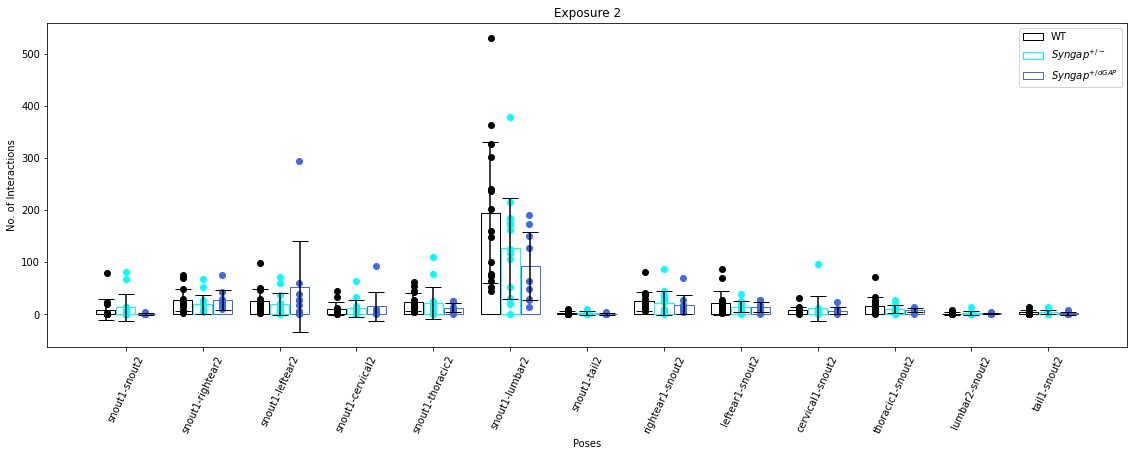

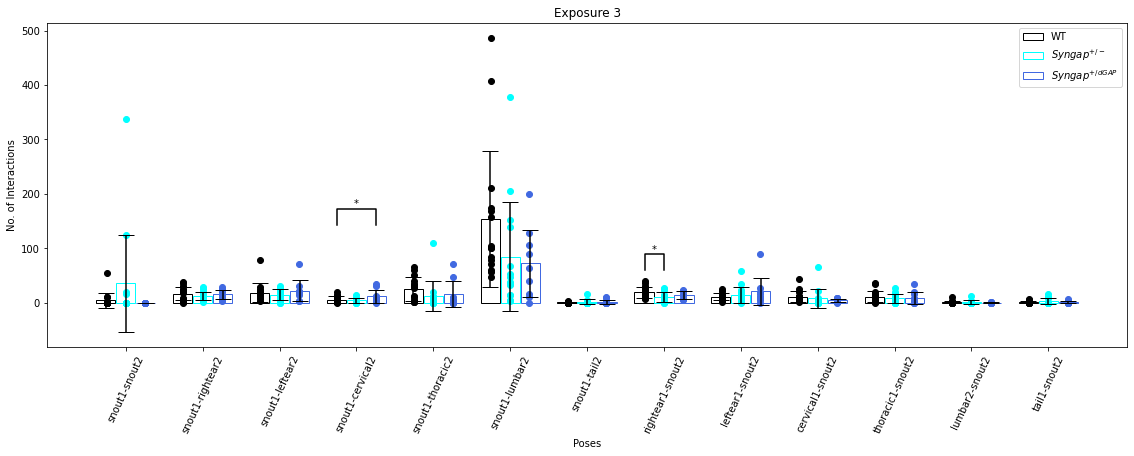

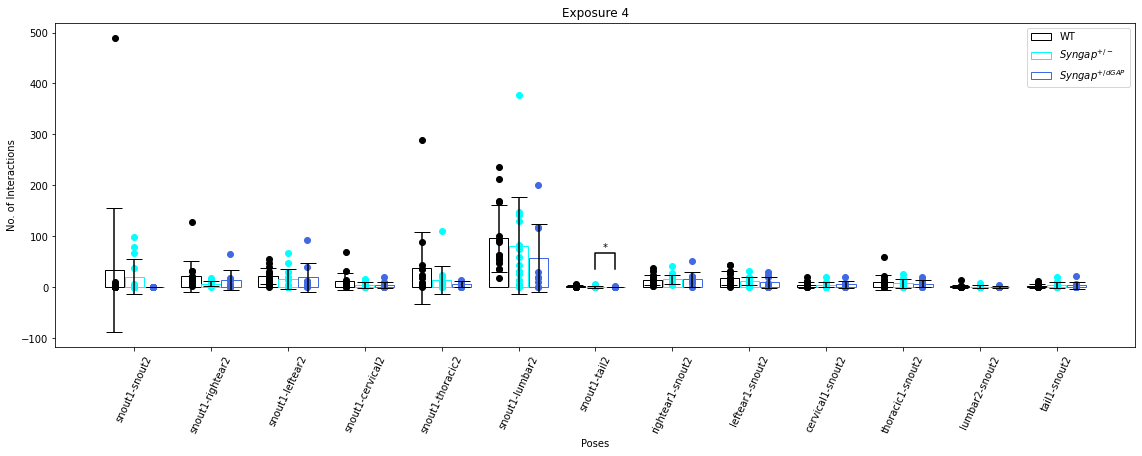

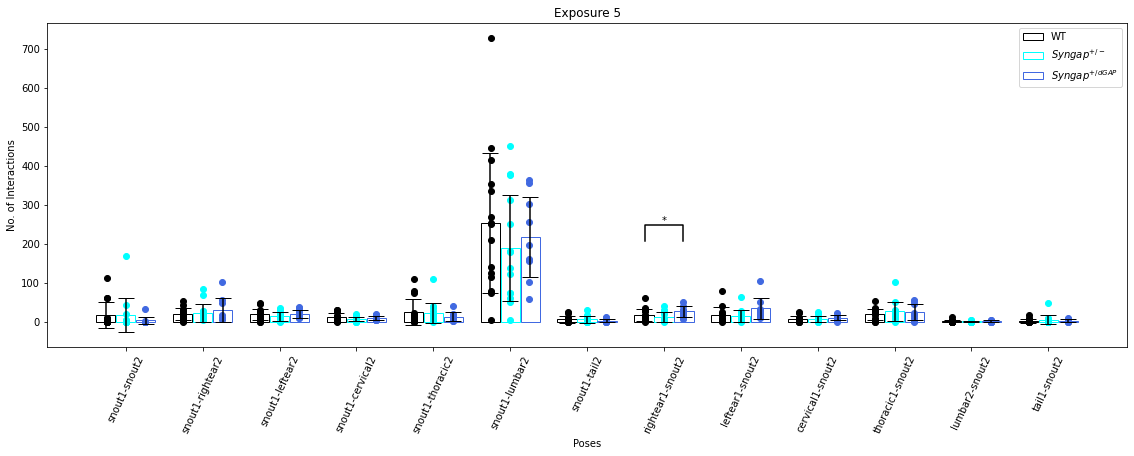

In [83]:
# https://stackoverflow.com/questions/51027717/pyplot-bar-charts-with-individual-data-points
anova_exposures = []
ttest_exposures = []
for ex, exposure in enumerate(l_exposures_number):
    data_bar = []
    data_scatter = []
    for g, genotype in enumerate(l_genotypes_per_exposure):
        #print(ex*len(l_genotypes_per_exposure) + g)
        data_scatter.append(l_all_data[ex*len(l_genotypes_per_exposure) + g])
    
    # Stats
    behaviors_anova = [] # 13 poses
    behaviors_ttest = [] # 13 poses with 3 ttest per behavior
    for behavior in X:
        F, anova_pvalue = stats.f_oneway(data_scatter[0][behavior], data_scatter[1][behavior], data_scatter[2][behavior])
        #print(data_scatter[0][behavior], data_scatter[1][behavior], data_scatter[2][behavior])
        #print(behavior_labels[behavior] + ' ANOVA: ' + str(F) + ' p-value: ' + str(anova_pvalue))
        behaviors_anova.append([F, anova_pvalue])
        l_ttest = []
        if anova_pvalue < 0.8: #0.05:
            for comb in ttest_comb:
                gen1 = l_genotypes_per_exposure.index(comb[0])
                gen2 = l_genotypes_per_exposure.index(comb[1])
                tst, t_pvalue = stats.ttest_ind(data_scatter[gen1][behavior], data_scatter[gen2][behavior])
                #print('t-test ' + comb[0] + '-' + comb[1] + ': ' + str(tst) + ' p-value: ' + str(t_pvalue))
                l_ttest.append([tst, t_pvalue])
        
        behaviors_ttest.append(l_ttest)
    
    # just in case we want to access them later on
    anova_exposures.append(behaviors_anova)
    ttest_exposures.append(behaviors_ttest)

    
    # Plotting
    fig = plt.figure(figsize=(20,6))

    X = np.arange(len(behavior_labels))
    ax = fig.add_axes([0.1,0.1,0.75,0.75])
    # Now set the ticks and labels
    ax.set_xticks(np.arange(len(behavior_labels)))
    ax.set_xticklabels(behavior_labels, rotation = 65)


    ax.legend(l_genotypes_per_exposure, ncol=3)


    plt.xlabel("Poses")
    plt.ylabel("No. of Interactions")
    title = 'Exposure ' + str(exposure)
    plt.title(title)

    heights = []
    yerrs = []
    total_heights = []
    
    # plotting the bars
    x_pos = -0.26
    for g, genotype in enumerate(l_genotypes_per_exposure):
        heights.append([np.mean(yi) for yi in data_scatter[g]])
        yerrs.append([np.std(yi) for yi in data_scatter[g]])
        total_heights.append([sum(x) for x in zip(heights[g],yerrs[g])])
        #print(heights[g])
        #print(yerrs[g])
        #print(total_heights[g])
        #print('\n')
        ax.bar(X + x_pos, height=heights[g], yerr=yerrs[g], capsize=8, color=(0,0,0,0), edgecolor=edgecolors[g], width = 0.25, label=labels[g])
        x_pos += 0.26
    
    # plotting the scatter per animal per pose per genotype
    for i in range(len(X)):
        #print (X[i])
        #print(data_scatter[0][i])
        xwt = np.ones(len(data_scatter[0][i]))*(X[i]-0.25)
        xe8 = np.ones(len(data_scatter[1][i]))*X[i]
        xgap = np.ones(len(data_scatter[2][i]))*(X[i]+0.25)
        #print(xgap)
        ax.scatter(xwt , data_scatter[0][i], color = 'black') #, color=colors[i])
        ax.scatter(xe8 , data_scatter[1][i], color = 'cyan') #, color=colors[i])
        ax.scatter(xgap, data_scatter[2][i], color = 'royalblue') #, color=colors[i])
    

    # plotting the significance of the t-test per each pose
    for behavior in X:
        heights_s = [total_heights[0][behavior], total_heights[1][behavior], total_heights[2][behavior]]
        bars = [X[behavior]-0.25, X[behavior], X[behavior]+0.25]
        if len(behaviors_ttest[behavior]) > 0:
            ttests = [behaviors_ttest[behavior][0][1], behaviors_ttest[behavior][1][1], behaviors_ttest[behavior][2][1]]
            if ttests[0] < 0.05: barplot_annotate_brackets(0, 1, ttests[0], bars, heights_s, axis_n=ax)
            if ttests[1] < 0.05: barplot_annotate_brackets(1, 2, ttests[1], bars, heights_s, axis_n=ax)
            if ttests[2] < 0.05: barplot_annotate_brackets(0, 2, ttests[2], bars, heights_s, dh=.2, axis_n=ax)
        else:
            ttests = ['n/a', 'n/a', 'n/a']
        
    
    
    plt.legend()
       
    plt.savefig('genotype_group_interaction_exposure_' + str(exposure) + '.png', dpi=300, bbox_inches='tight', edgecolor='white')

In [84]:
anova_exposures = []
ttest_exposures = []
for ex, exposure in enumerate(l_exposures_number):
    data_bar = []
    data_scatter = []
    for g, genotype in enumerate(l_genotypes_per_exposure):
        #print(ex*len(l_genotypes_per_exposure) + g)
        data_scatter.append(l_all_data[ex*len(l_genotypes_per_exposure) + g])
    
    # Stats
    behaviors_anova = [] # 13 poses
    behaviors_ttest = [] # 13 poses with 3 ttest per pose
    for behavior in X:
        #equal_variance = data_scatter[0][behavior], data_scatter[1][behavior], data_scatter[2][behavior]
        #print(equal_variance)
        F, anova_pvalue = stats.f_oneway(data_scatter[0][behavior], data_scatter[1][behavior], data_scatter[2][behavior])
        #print(data_scatter[0][behavior], data_scatter[1][behavior], data_scatter[2][behavior])
        #print(behavior_labels[behavior] + ' ANOVA: ' + str(F) + ' p-value: ' + str(anova_pvalue))
        behaviors_anova.append([F, anova_pvalue])
        l_ttest = []
        if anova_pvalue < 0.8: #0.05:
            for comb in ttest_comb:
                gen1 = l_genotypes_per_exposure.index(comb[0])
                gen2 = l_genotypes_per_exposure.index(comb[1])
                tst, t_pvalue = stats.ttest_ind(data_scatter[gen1][behavior], data_scatter[gen2][behavior])
                #print('t-test ' + comb[0] + '-' + comb[1] + ': ' + str(tst) + ' p-value: ' + str(t_pvalue))
                l_ttest.append([tst, t_pvalue])
        
        behaviors_ttest.append(l_ttest)
    
    # just in case we want to access them later on
    anova_exposures.append(behaviors_anova)
    ttest_exposures.append(behaviors_ttest)


In [85]:
anova_exposures = []
ttest_exposures = []
for ex, exposure in enumerate(l_exposures_number):
    data_bar = []
    data_scatter = []
    for g, genotype in enumerate(l_genotypes_per_exposure):
        #print(ex*len(l_genotypes_per_exposure) + g)
        data_scatter.append(l_all_data[ex*len(l_genotypes_per_exposure) + g])
        
    for behavior in X:
        equal_variance = stats.levene(data_scatter[0][behavior], data_scatter[1][behavior], data_scatter[2][behavior])
        #print(equal_variance)

In [86]:
#bonferroni correction - adjusted p values 
from statsmodels.sandbox.stats.multicomp import multipletests

anova_exposures = []
ttest_exposures = []
for ex, exposure in enumerate(l_exposures_number):
    data_bar = []
    data_scatter = []
    for g, genotype in enumerate(l_genotypes_per_exposure):
        #print(ex*len(l_genotypes_per_exposure) + g)
        data_scatter.append(l_all_data[ex*len(l_genotypes_per_exposure) + g])
    
    # Stats
    behaviors_anova = [] # 13 poses
    behaviors_ttest = [] # 13 poses with 3 ttest per pose
    for behavior in X:
        #equal_variance = data_scatter[0][behavior], data_scatter[1][behavior], data_scatter[2][behavior]
        #print(equal_variance)
        F, anova_pvalue = stats.f_oneway(data_scatter[0][behavior], data_scatter[1][behavior], data_scatter[2][behavior])
        #print(data_scatter[0][behavior], data_scatter[1][behavior], data_scatter[2][behavior])
        #print(behavior_labels[behavior] + ' ANOVA: ' + str(F) + ' p-value: ' + str(anova_pvalue))
        behaviors_anova.append([F, anova_pvalue])
        l_ttest = []
        if anova_pvalue < 0.8: #0.05:
            for comb in ttest_comb:
                gen1 = l_genotypes_per_exposure.index(comb[0])
                gen2 = l_genotypes_per_exposure.index(comb[1])
                tst, t_pvalue = stats.ttest_ind(data_scatter[gen1][behavior], data_scatter[gen2][behavior])
                #print('t-test ' + comb[0] + '-' + comb[1] + ': ' + str(tst) + ' p-value: ' + str(t_pvalue) + ' adjusted p-value: ' + str(adjusted_t_pvalues))
                adjusted_t_pvalues =multipletests(t_pvalue, method = 'bonferroni')
                l_ttest.append([tst, t_pvalue, adjusted_t_pvalues])
        
        behaviors_ttest.append(l_ttest)
    
    # just in case we want to access them later on
    anova_exposures.append(behaviors_anova)
    ttest_exposures.append(behaviors_ttest)